In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#import qiskit.quantum_info as qi



#from qiskit import Aer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature import settings
from qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.primitives import Estimator


In [2]:
def reset_intermediate_info():
    global intermediate_info
    intermediate_info.clear()
    print(intermediate_info)
    intermediate_info = {
        'nfev ': [],
        'parameters ': [],
        'energy ': [],
        'stddev ': []
    }

def callback (nfev , parameters , energy , stddev ):
    intermediate_info ['nfev ']. append ( nfev )
    intermediate_info ['parameters ']. append ( parameters )
    intermediate_info ['energy ']. append ( energy )
    intermediate_info ['stddev ']. append ( stddev )

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

In [7]:
def FMO_calc(C,L,theta):    
    
    Co = (0,0,0)
    O_1 = (C,0,0)
    O_2 = (C*np.cos(theta),C*np.sin(theta),0)
    Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)

    O_monomer_atoms = ["O"]
    O_monomer_coords = [(0,0,0)]
    O_monomer_charge = 0
    O_monomer_multiplicity = 3

    O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

    driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((3,1), 3)
    as_problem = as_transformer.transform(E_problem)
    E_O = least_Energy(as_problem)

    O_monomer_atoms = ["Li"]
    O_monomer_coords = [(0,0,0)]
    O_monomer_charge = 0
    O_monomer_multiplicity = 2

    O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

    driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
    E_problem = driver.run()

    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((2,1), 2)
    as_problem = as_transformer.transform(E_problem)
    E_Li = least_Energy(as_problem)
    
    O_monomer_atoms = ["Co"]
    O_monomer_coords = [(0,0,0)]
    O_monomer_charge = 0
    O_monomer_multiplicity = 4

    O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

    driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
    E_problem = driver.run()

    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((6,3), 6)
    as_problem = as_transformer.transform(E_problem)
    E_Co = least_Energy(as_problem)

    Co_O_dimer_atoms = ["Co", "O"]
    Co_O_dimer_coords = [Co, O_2]
    Co_O_dimer_charge = 0
    Co_O_dimer_multiplicity = 2
    Co_O_moleculeinfo = MoleculeInfo(Co_O_dimer_atoms, Co_O_dimer_coords, charge=Co_O_dimer_charge, multiplicity=Co_O_dimer_multiplicity)

    driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((6,5), 8)
    as_problem = as_transformer.transform(E_problem)
    E_5= least_Energy(as_problem)

    #Single-bond
    Co_O_dimer_atoms = ["Co", "O"]
    Co_O_dimer_coords = [Co, O_1]
    Co_O_dimer_charge = 0
    Co_O_dimer_multiplicity = 4
    Co_O_moleculeinfo = MoleculeInfo(Co_O_dimer_atoms, Co_O_dimer_coords, charge=Co_O_dimer_charge, multiplicity=Co_O_dimer_multiplicity)
    driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((7,4), 8)
    as_problem = as_transformer.transform(E_problem)
    E_6 = least_Energy(as_problem)

    O_Li_dimer_atoms = ["O", "Li"]
    O_Li_dimer_coords = [O_1, Li]
    O_Li_dimer_charge = 0
    O_Li_dimer_multiplicity = 2

    O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)
    driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((3,2), 4)
    as_problem = as_transformer.transform(E_problem)
    E_1 = least_Energy(as_problem)

    O_Li_dimer_atoms = ["O", "Li"]
    O_Li_dimer_coords = [O_2, Li]
    O_Li_dimer_charge = 0
    O_Li_dimer_multiplicity = 4

    O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

    driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((4,1), 4)
    as_problem = as_transformer.transform(E_problem)
    E_2 = least_Energy(as_problem)

    Co_Li_dimer_atoms = ["Co", "Li"]
    Co_Li_dimer_coords = [Co, Li]
    Co_Li_dimer_charge = 0
    Co_Li_dimer_multiplicity = 5
    energy_arr =[]
    order=[]
    Co_Li_moleculeinfo = MoleculeInfo(Co_Li_dimer_atoms, Co_Li_dimer_coords, charge=Co_Li_dimer_charge, multiplicity=Co_Li_dimer_multiplicity)

    driver = PySCFDriver.from_molecule(Co_Li_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((6,2), 6)
    as_problem = as_transformer.transform(E_problem)
    E_3 = least_Energy(as_problem)

    O_O_dimer_atoms = ["O", "O"]
    O_O_dimer_coords = [O_1, O_2]
    O_O_dimer_charge = 0
    O_O_dimer_multiplicity = 3
    energy_arr =[]
    order=[]
    O_O_moleculeinfo = MoleculeInfo(O_O_dimer_atoms, O_O_dimer_coords, charge=O_O_dimer_charge, multiplicity=O_O_dimer_multiplicity)

    driver = PySCFDriver.from_molecule(O_O_moleculeinfo, basis=basis)
    E_problem = driver.run()
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    as_transformer = ActiveSpaceTransformer((6,2), 6)
    as_problem = as_transformer.transform(E_problem)
    E_4 = least_Energy(as_problem)

    Exact_arr = [E_1,E_2,E_3,E_4,E_5,E_6]

    return Exact_arr


In [8]:
basis = 'sto3g'
settings.use_pauli_sum_op = False

# x = 1
C = 1.9220
L = 2.0946
theta = np.deg2rad(94.24)

E_1=FMO_calc(C,L,theta)
print(E_1)

[np.float64(-73.25952082044347), np.float64(-73.89589403421802), np.float64(-1357.6599074801616), np.float64(-131.43975636674833), np.float64(-1411.269176730623), np.float64(-1411.2629021755706)]


[np.float64(-73.25952082044347), np.float64(-73.89589403421802), np.float64(-1357.6599074801616), np.float64(-131.43975636674833), np.float64(-1411.269176730623), np.float64(-1411.2629021755706)]
[np.float64(0.0), np.float64(-67.22326395627233), np.float64(-1339.3961057503936)]
-1511.1018902818882
[np.float64(-73.25940531329204), np.float64(-73.89582310718428), np.float64(-1357.6705967534697), np.float64(-131.43892187122805), np.float64(-1411.0876174599011), np.float64(-1411.3410399259146)]
[np.float64(0.0), np.float64(-67.22326395627233), np.float64(-1339.3961057503936)]
-1511.0081371051133
[np.float64(-73.2451974467489), np.float64(-73.89377989460759), np.float64(-1357.6673080901917), np.float64(-131.43760293046375), np.float64(-1411.3750142008823), np.float64(-1411.2467857254044)]
[np.float64(0.0), np.float64(-67.22326395627233), np.float64(-1339.3961057503936)]
-1511.180420962422
[np.float64(-73.24519741018679), np.float64(-73.89377068046687), np.float64(-1357.6686779789006), np.fl

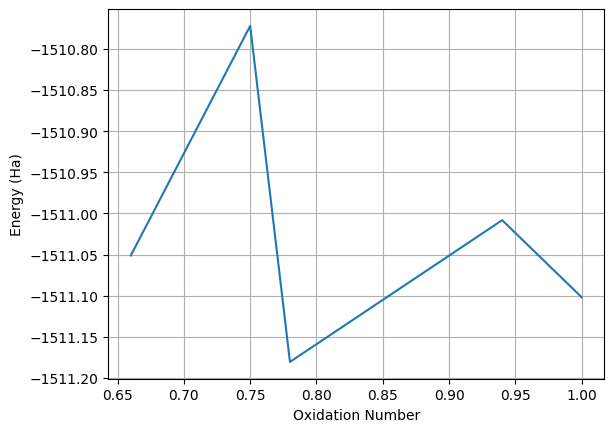

In [5]:
basis = 'sto3g'
settings.use_pauli_sum_op = False

# x = 1
C = 1.9220
L = 2.0946
theta = np.deg2rad(94.24)

E_1=FMO_calc(C,L,theta)

# x= 0.94
C = 1.9210
L = 2.0944
theta = np.deg2rad(94.27)
E_94=FMO_calc(C,L,theta)

#x = 0.78
C = 1.9132
L = 2.07
theta = np.deg2rad(94.72)
# 

# #x = 0.78(다른거)
# C = 1.9132
# L = 2.12
# theta = np.deg2rad(94.72)

E_78=FMO_calc(C,L,theta)

#x = 0.75
C = 1.9059
L = 2.07
theta = np.deg2rad(95.07)

# # x = 0.75(다른거))
# C = 1.9059
# L = 2.13
# theta = np.deg2rad(95.07)

E_75=FMO_calc(C,L,theta)


# # x= 0.66
C = 1.9032
L = 2.07
theta = np.deg2rad(95.24)

# x= 0.66(다른거)
# C = 1.9032
# L = 2.14
# theta = np.deg2rad(95.24)

E_66=FMO_calc(C,L,theta)

FMO_exact = [E_66,E_75,E_78,E_94,E_1]
x = [0.66,0.75,0.78,0.94,1]

plt.plot(x,FMO_exact)
plt.xlabel('Oxidation Number')
plt.ylabel('Energy (Ha)')
plt.ticklabel_format(style='plain', axis='y')  # 과학적 표기 X
plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # 일반 숫자 포맷
plt.gca().ticklabel_format(useOffset=False, style='plain')  # 진짜 값으로
plt.grid()
plt.show()
plt.show()

In [6]:
print(FMO_exact)

[np.float64(-1511.0510632522032), np.float64(-1510.7720902416), np.float64(-1511.180420962422), np.float64(-1511.0081371051133), np.float64(-1511.1018902818882)]
